In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import defaultdict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.feature_selection import mutual_info_classif

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


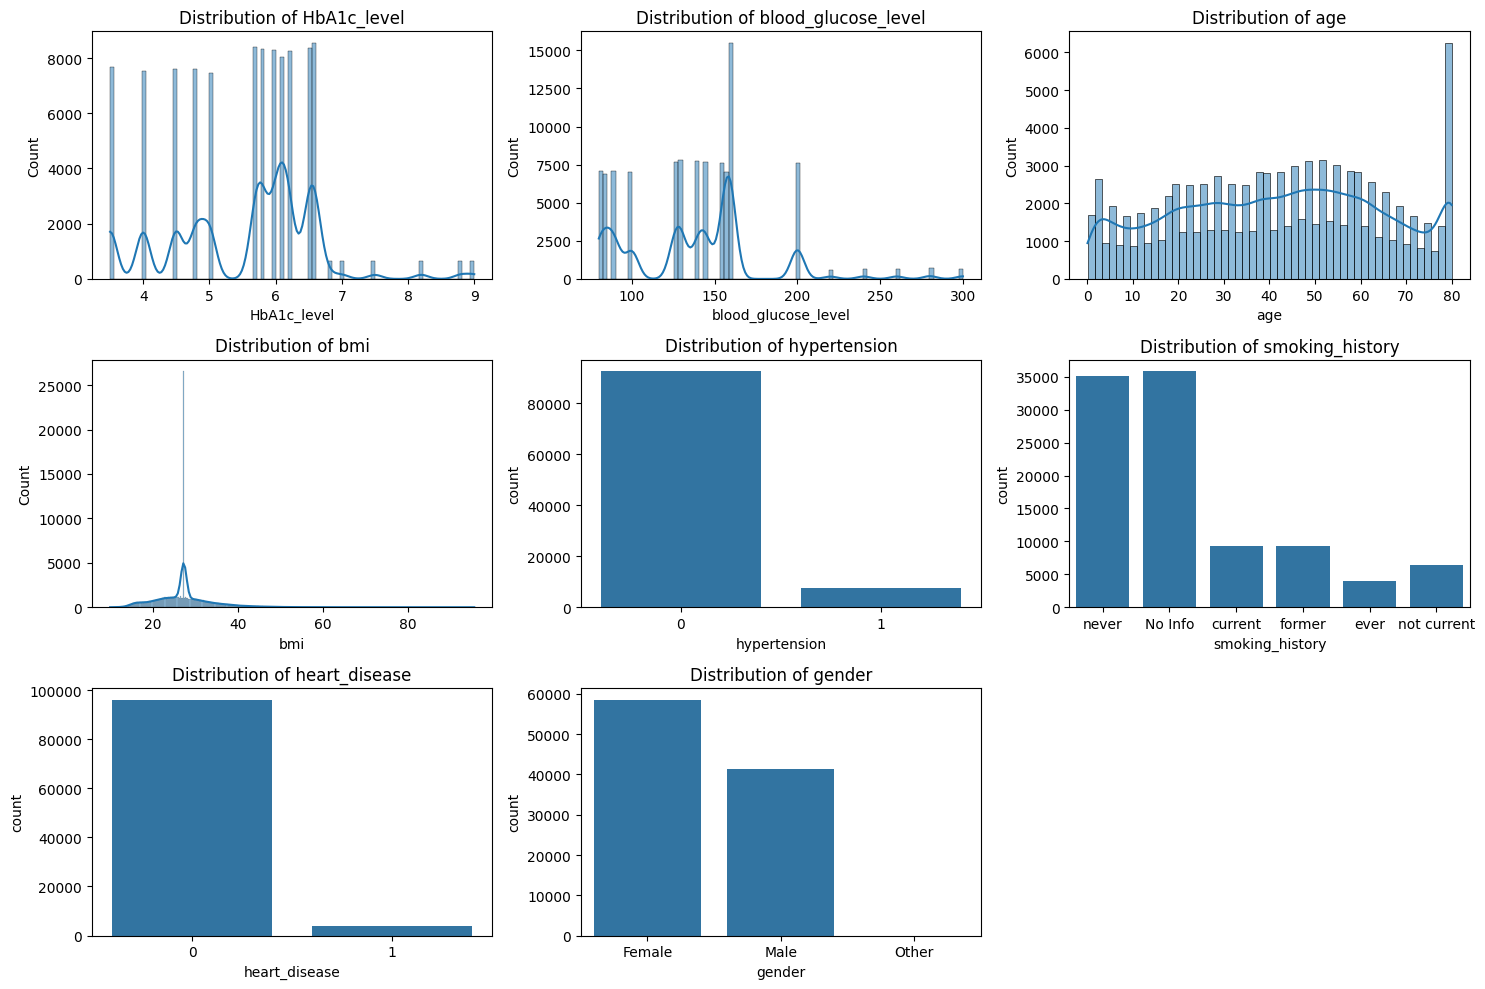

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/diabetes_prediction_dataset.csv')

plt.figure(figsize=(15, 10))

cont = ['HbA1c_level', 'blood_glucose_level', 'age', 'bmi']
for i, var in enumerate(cont, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df2[var], kde=True)
    plt.title(f'Distribution of {var}')

cat = ['hypertension', 'smoking_history', 'heart_disease', 'gender']
for i, var in enumerate(cat, len(cont) + 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=var, data=df2)
    plt.title(f'Distribution of {var}')

plt.tight_layout()

plt.show()

Label Encoding for Categorical Variables

In [ ]:
#We will not encode numerical columns such as age, BMI, HbA1c level, blood glucose level. In addition, binary columns such as hyptertension,
# heart disease, and diabetes are already in binary format. Thus, we will proceed to encode 'gender' and 'smoking_history'.

from sklearn.preprocessing import LabelEncoder
import pandas as pd
import io

label_encoder = LabelEncoder()

#gender column
df['gender_encoded'] = label_encoder.fit_transform(df['gender'])

#smoking history
df['smoking_history_encoded'] = label_encoder.fit_transform(df['smoking_history'])

df = df[['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes', 'gender_encoded', 'smoking_history_encoded']]
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_encoded,smoking_history_encoded
0,80.0,0,1,25.19,6.6,140,0,0,4
1,54.0,0,0,27.32,6.6,80,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,4
3,36.0,0,0,23.45,5.0,155,0,0,1
4,76.0,1,1,20.14,4.8,155,0,1,1


Feature Scaling

Selecting Features To Scale:
We are defining which features to scale, which are the continuous numerical features. Categorical features have already been encoded in the previous step.

In [ ]:
numerical_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']

We are using standardization for the numerical features.

In [ ]:
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_encoded,smoking_history_encoded
0,1.692704,-0.284439,4.936379,-0.321056,1.001706,0.047704,0,0,4
1,0.538006,-0.284439,-0.202578,-0.000116,1.001706,-1.426210,0,0,0
2,-0.616691,-0.284439,-0.202578,-0.000116,0.161108,0.489878,0,1,4
3,-0.261399,-0.284439,-0.202578,-0.583232,-0.492690,0.416183,0,0,1
4,1.515058,3.515687,4.936379,-1.081970,-0.679490,0.416183,0,1,1


Now, we will use mutual information to perform feature selection. Mutual information is a non-negative value that measures the dependency between the variables. A larger value indicates a stronger relationship with the target variable.

In [ ]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

mutual_info = mutual_info_classif(X, y)
mutual_info_df = pd.DataFrame({'feature': X.columns, 'mutual_info': mutual_info})
mutual_info_sorted = mutual_info_df.sort_values('mutual_info', ascending=False)
mutual_info_sorted
selected_features = mutual_info_sorted[mutual_info_sorted['mutual_info'] > 0]['feature']

df = df[selected_features.tolist() + ['diabetes']]
df.head()

,HbA1c_level,blood_glucose_level,age,bmi,hypertension,smoking_history_encoded,heart_disease,gender_encoded,diabetes
0,1.001706,0.047704,1.692704,-0.321056,-0.284439,4,4.936379,0,0
1,1.001706,-1.426210,0.538006,-0.000116,-0.284439,0,-0.202578,0,0
2,0.161108,0.489878,-0.616691,-0.000116,-0.284439,4,-0.202578,1,0
3,-0.492690,0.416183,-0.261399,-0.583232,-0.284439,1,-0.202578,0,0
4,-0.679490,0.416183,1.515058,-1.081970,3.515687,1,4.936379,1,0


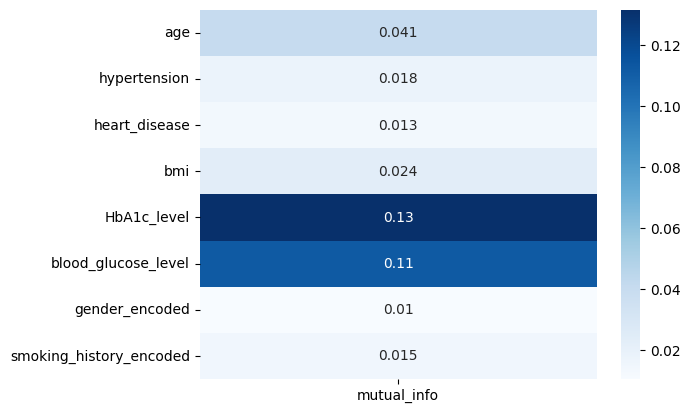

In [ ]:
mutual_info = mutual_info_classif(X, y)
sns.heatmap(pd.DataFrame(mutual_info, index=X.columns, columns=['mutual_info']), cmap="Blues", annot=True)
plt.show()

The DataFrame remains unchanged with all original features plus the diabetes target column. However, with such a small dataset (as the one shown), the reliability of mutual information scores and other feature selection methods may be compromised. This concludes preprocessing, and the model can be built.

#Model Implementation - Logistic Regression

Logistic regression was chosen since it works well for binary classification tasks. It simulates the likelihood that an input falls into a specific category (in this case, diabetes or not).



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}\n")
conf_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("Confusion Matrix:")
print(conf_matrix_df)
print("\n")
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report:")
print(report_df)

Accuracy: 0.95865

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               18127                 165
Actual Positive                 662                1046


Classification Report:
              precision    recall  f1-score      support
0              0.964767  0.990980  0.977697  18292.00000
1              0.863749  0.612412  0.716684   1708.00000
accuracy       0.958650  0.958650  0.958650      0.95865
macro avg      0.914258  0.801696  0.847191  20000.00000
weighted avg   0.956140  0.958650  0.955407  20000.00000


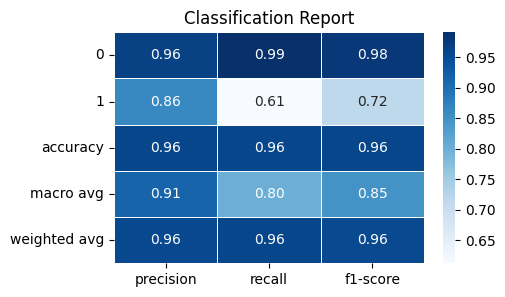

In [ ]:
#no need for support
performance_metrics_df = report_df.drop('support', axis=1)

plt.figure(figsize=(5, 3))
sns.heatmap(performance_metrics_df, annot=True, cmap="Blues", linewidths=.5, fmt=".2f")
plt.title('Classification Report')
plt.show()


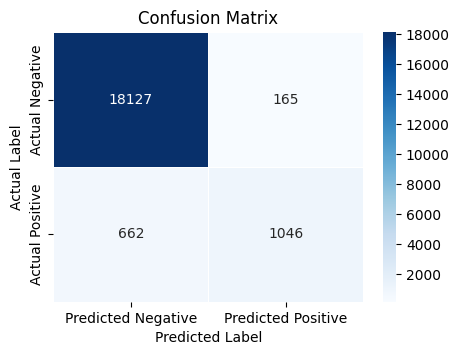

In [ ]:
plt.figure(figsize=(5, 3.5))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Quantitative Metrics - Logistic Regression:

Given the values from the confusion matrix:


**True Negative (TN)**: 18127 \\
**False Positive (FP)**: 165 \\
**False Negative (FN)**: 662 \\
**True Positive (TP)**: 1046 \\


The formulas for the quantative metrics are:

\begin{align*}
    \text{Accuracy} &= \frac{TP + TN}{TP + TN + FP + FN} \\
    \text{Recall} &= \frac{TP}{TP + FN} \\
    \text{Precision} &= \frac{TP}{TP + FP} \\
    \text{F1} &= 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\end{align*}

Evaluating the formulas with the above values we get:

\begin{align*}
    \text{Accuracy} &= \frac{1046 + 18127}{1046 + 18127 + 165 + 662} \approx 95.865\% \\
    \text{Recall} &= \frac{1046}{1046 + 662} \approx 61.241\% \\
    \text{F1 Score} &= 2 \times \frac{\frac{1046}{1046 + 165} \times \frac{1046}{1046 + 662}}{\frac{1046}{1046 + 165} + \frac{1046}{1046 + 662}} \approx 71.668\%
\end{align*}

## Analysis - Logistic Regression

### Classification Report
The report for each class (0 for the negative class which represents non-diabetes cases, and 1 for the positive class which likely represents diabetes cases) shows precision, recall, and f1-score.

- **Precision**: This is the ratio of correctly predicted positive cases to the total predicted positive cases. So essentially, a high precision implies a low false positive rate. For the non-diabetes class (0), the precision is approximately 96.47%, which is relatively high. This suggests that the model is reliable in predicting cases of non-diabetes. For the diabetes class (1), the precision is approximately 86.37%, which is not as precise as the non-diabetes class, but still reasonably high. This indicates that most of the cases predicted as diabetes are actually diabetes.

- **Recall**: This is the ratio of correctly predicted positive cases to all cases in the class, also known as the true positive rate. The non-diabetes (0) class has a recall of approximately 99.90%, which shows that the model is very good at predicting non-diabetes cases. But on the other hand, the diabetes class (1) has a lower recall of about 61.24%. This suggests that the model misses a good number of actual diabetes cases.

- **F1-Score**: This is the harmonic mean of precision and recall. So, it assesses both false positives and false negatives and shows if a class has a balance of precision and recall. The F1 score for the non-diabetes class (0) is approximately 97.77%, while for the diabetes class (1) it's lower at 71.66%. This suggest that there is not a good balance between precision and recall for the diabetes class.

### Confusion Matrix and Overall Metrics

- **Accuracy**: This is the ratio of correctly predicted cases to the total number of cases. The overall accuracy is 95.86%, which is implies a high-performing model.

- **Macro Average**: This averages the unweighted mean per label, so it doesn't take label imbalance into account. The macro average for precision, recall, and F1-score are approximately 91.42%, 80.16%, and 84.72% respectively. This suggests the model performs well overall, but there is an imbalance in performance between the two classes.

- **Weighted Average**: This averages the support-weighted mean per label. This accounts for label imbalance by weighing the metrics by the number of true instances for each label. Support is the number of cases of a class in the dataset. The weighted averages for precision, recall, and F1-score are approximately 95.61%, 95.86%, and 95.54% respectively, which suggests that when noting the imbalance, the model still demonstrates a high performance.

### Remarks

In the context of predicting diabetes, the relatively low recall for diabetes cases (1) is something that needs to improve, because it suggests that the model fails to predict a decent portion of actual positive diabetes cases. This is an important issue especially considering this is used in the context of medical diagnosis as failing to diagnose a disease could lead to serious health problems experienced by the patient.

### 2nd Model Implementation - Decision Tree Classifier

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}\n")

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=['Actual Negative', 'Actual Positive'],
    columns=['Predicted Negative', 'Predicted Positive']
)
print("Confusion Matrix:")
print(conf_matrix_df)
print("\n")

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report:")
print(report_df)


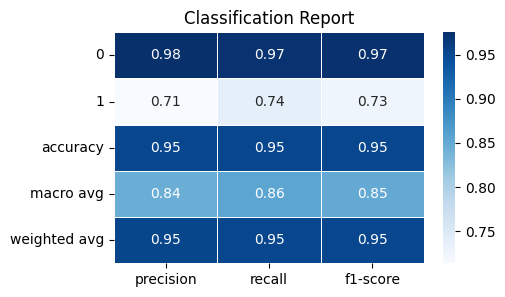

In [ ]:
performance_metrics_df = report_df.drop('support', axis=1)

plt.figure(figsize=(5, 3))
sns.heatmap(performance_metrics_df, annot=True, cmap="Blues", linewidths=.5, fmt=".2f")
plt.title('Classification Report')
plt.show()

**ANALYSIS**

We used a Decision Tree Classifier, a non-parametric supervised learning technique, to solve our diabetes prediction problem. By learning simple decision rules inferred from the data features, the classifier creates a model that forecasts the value of the target variable.

For reproducibility, we used the DecisionTreeClassifier from sklearn.tree with a specific random_state. All columns other than the final one, which represented the target variable y, were used to derive our feature matrix X.
Our dataset was split into a 20–80 test–train ratio, with 20% set aside for model testing. The X_train and y_train datasets were used to train the classifier.


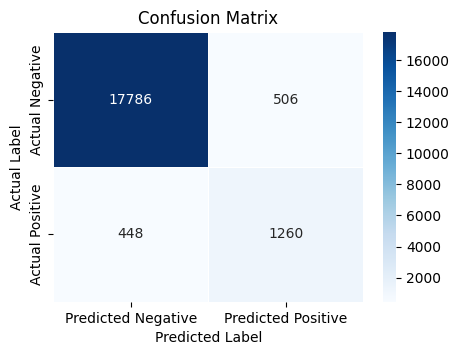

In [ ]:
plt.figure(figsize=(5, 3.5))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Accuracy - The Decision Tree Classifier achieved an accuracy of 95.23%, which indicates a high level of overall correct predictions.

The Confusion Matrix has revealed the following:

*   True Negative (TN): 17786, meaning the model correctly predicted the non-diabetic cases
*   False Positive (FP): 506, where the model incorrectly predicted diabetes
*   False Negative(FN): 448, where the model failed to correctly identify diabetic causes
*   True Positive (TN): 1260, representing correct diabetic predictions


These values suggest that even though the model is highly useful and robust in predicting non-diabetic cases, it has room for improvement in correctly identifying diabetic cases, as seen by the number of false negatives.


Classification Report:

<summary><b>Precision Analysis</b>
<p>The precision is almost 97.54% for the non-diabetic class (0) and 71.34% for the diabetes class (1). In comparison to instances with diabetes, the model predicts non-diabetic cases more accurately.</p>

<summary><b>Recall Analysis</b></summary>
<p>The recall rate is considerably lower for the diabetic class (73.77%) than it is for the non-diabetic class (97.23%). This suggests that the model's capacity to identify actual instances of diabetes has to be strengthened.</p>

<summary><b>F1-Score Analysis</b></summary>
<p>Precision and recall are balanced by the F1-score, which is higher for the non-diabetic class (about 97.38%) and lower for the diabetic class (72.54%).</p>

<summary><b>Accuracy Analysis</b></summary>
<p>Accuracy (0.95): 95% of the time, the Decision Tree Classifier correctly predicted both the diabetes and non-diabetic classifications. A high accuracy rate indicates that the model can consistently distinguish between the classes over the full dataset.</p>

<summary><b>Macro Average Analysis</b></summary>
<p>Macro Average (Precision: 0.84, Recall: 0.86, F1-Score: 0.85): The model's average performance over the two classes is displayed by the macro average, which offers a performance estimate that treats every class equally. It provides equal weight to the performance measurements of the majority and minority classes since it ignores class inequality. The macro average scores, which are close to 0.85, indicate that the model performs reasonably well in both classes, however they might not accurately represent results from an unbalanced dataset.</p>

<summary><b>Weighted Average Analysis</b></summary>
<p>Weighted Average (Precision: 0.95, Recall: 0.95, F1-Score: 0.95): By dividing the number of true occurrences in each class by the performance indicator, the weighted average accounts for the imbalance in class sizes. Because it takes into consideration the relative sizes of each class, this provides a more realistic assessment of the model's predictive ability on the dataset. The model is quite effective at predicting in proportion to how common each class is in the data, as seen by the high weighted average scores.</p>


<b>Below is the code for the performance metric calculations:</b>

In [ ]:

# Define the metric calculation functions
def calculate_accuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + TN + FP + FN)

def calculate_recall(TP, FN):
    return TP / (TP + FN)

def calculate_precision(TP, FP):
    return TP / (TP + FP)

def calculate_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

# Given values
TP = 1260  # True Positives
TN = 17786 # True Negatives
FP = 506   # False Positives
FN = 448   # False Negatives

# Calculate the metrics
accuracy = calculate_accuracy(TP, TN, FP, FN)
recall = calculate_recall(TP, FN)
precision = calculate_precision(TP, FP)
f1_score = calculate_f1_score(precision, recall)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Accuracy: 0.9523
Recall: 0.7377
Precision: 0.7135
F1 Score: 0.7254


Improvements:
The Decision Tree Classifier is highly accurate in predicting diabetes, with strong precision and recall in non-diabetic situations. However, the recall for diabetes cases can be improved to ensure that the model does not overlook genuine diabetic patients.

Given the model's performance metrics here's some improvements:
Pruning the Tree: To prevent overfitting, we could prune the decision tree to limit its depth or the minimum number of samples required at a leaf node.
Feature Engineering: Exploring more features or creating new ones could help the model differentiate better between diabetic and non-diabetic cases.
Ensemble Methods: Employing ensemble methods like Random Forests could improve performance by overcoming the limitations of a single decision tree.


The Decision Tree Classifier is a reliable model for making initial diabetes predictions. Its transparency and interpretability make it an appealing choice for healthcare professionals. Yet additional modification is required to improve its clinical value, particularly in reducing the number of missed diabetes cases.

#3rd Model Implementation: Random Forest Model

We chose random forest for this because of its ability to handle non-linear relationships and different data types. It's good at preventing overfitting due to its use of bootstrapping to get multiple training sets and its use of feature randomizing. It can also rank the importance of different features which is especially helpful in figuring out which predictors impact diabetes diagnosis.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

X = df.drop('diabetes', axis=1)
y = df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}\n")
conf_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("Confusion Matrix:")
print(conf_matrix_df)
print("\n")
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report:")
print(report_df)


Accuracy: 0.97050

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               18230                  62
Actual Positive                 528                1180


Classification Report:
              precision    recall  f1-score     support
0              0.971852  0.996611  0.984076  18292.0000
1              0.950081  0.690867  0.800000   1708.0000
accuracy       0.970500  0.970500  0.970500      0.9705
macro avg      0.960966  0.843739  0.892038  20000.0000
weighted avg   0.969993  0.970500  0.968356  20000.0000


**Here's the visualization of the classification report**

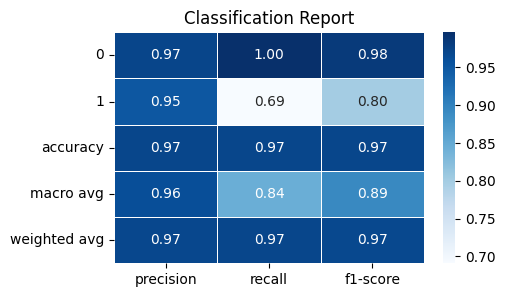

In [ ]:
#no need for support
performance_metrics_df = report_df.drop('support', axis=1)

plt.figure(figsize=(5, 3))
sns.heatmap(performance_metrics_df, annot=True, cmap="Blues", linewidths=.5, fmt=".2f")
plt.title('Classification Report')
plt.show()

**Here's the visualization of the confusion matrix**

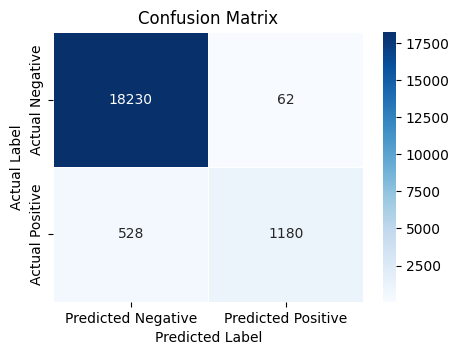

In [ ]:
plt.figure(figsize=(5, 3.5))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#Analysis
Given the values from the confusion matrix:

True Negative (TN): 18230
False Positive (FP): 62
False Negative (FN):528
True Positive (TP): 1180

Given these values, we can attain some performance metrics.

For accuracy, we attain the value of 0.9705 using this formula below:

TP + TN / (TP + TN + FP + FN) = 1180 + 18230 / (1180 + 18230 + 62 + 528)

For precision, we attain the value of 0.95 using the formula below:

TP / (TP + FN) = 1180 / (1180 + 528)

For the F1 score, we attain the value of 0.80 using the formula below:

2 * (Precision * Recall) / (Precision + Recall)

We can continue our analysis by looking at the Classification Report closely.

- Precision: For class 0, which is the non-diabetic class, the precision is 0.97 which indicates that the model accurately predicts no diabetes 97% of the time. On the other hand, for class 1, which is predicting diabetes, the model accurately does that 95% of the time. \\

- Recall: For class 0, the recall of 1.00 indicates that the model is perfect in identifying all cases of ‘no diabetes’ correctly, which is excellent. For class 1, the recall is only 0.69, which is relatively lower, meaning that only 69% of the diabetes cases were identified correctly.
F1-Score: For class 0, the F1 score is 0.98 which is very high, showcasing the excellent balance between precision and recall. As we calculated before, for class 1, the F1 score for predicting diabetes is 0.80 which highlights that there is a reasonable balance between precision and recall; however, it definitely could be better. \\

- Accuracy: As shown above from the printed statements, this model has an overall accuracy of 97% which is great and very high. It allows us to accurately predict if one has diabetes 97% of the time. \\


- Macro Average: This classification allows us to calculate the metrics (precision, recall, F1) for each class independently and then take the average of it without taking into account the frequency of it. From the report, we can see the macro average precision is 0.94, the macro average recall is 0.84, and the macro average F1-score is 0.89. The F1-score accurately depicts that while the precision score is high, the recall, which shows the ratio of correctly predicted cases, is lower and has room for improvement for identifying positive instances. \\


- Weighted Average: This is another way to identify the average performance of a model across all the classes while taking into account the imbalance in the distribution of the classes, giving more weight to the larger class. We can see from the report that the weighted average precision is 0.97, the weighted average recall is 0.97, and thus the F1 score is also 0.97. This shows that the performance for class 0, which has the most instances, is very strong and influences the overall metrics.\\

#Improvements

Overall, from our analysis we can see that our model is better at identifying the negative classes. This is displayed by the lower number of positive recalls, and thus, even though the model is overall accurate, it needs to be improved in correctly identifying positive cases of diabetes. If an actual case of diabetes is missed in a diagnosis, it could have severe implications for a patient.

To address the low recall for class 1, we could apply some resampling techniques to fix the class imbalances. This will help balance the dataset and improve performance for the underrepresented class. In addition, we could also adjust the class_weight parameter such that we could penalize mistakes on the minority class (1) to the amount of how proportionally underrepresented it is. Finally, we could address feature selection and add that preprocessing method to select the most relevant features; this would help us focus on the most important predictors.

# Next Steps
A goal to improve this model would be to address it's low recall. There are multiple different approaches that can be taken to mitigate this issue. We can try lowering the threshold of 0.5 in the logisitic regression model. However, this might lead to more false positives. We could also implement more cost-sensitive training through the class_weight parameter. We can adjust this parameter to penalize when there's a misclassification of the positive class more than the negative class. This will incentivize the model to reduce the number of false negatives and thereby increase recall. Finally, we could employ more feature training to have better distinctions between the two classes. By denoising our model and removing irrelevant features, the model can become better at identifying true positive cases (which it was lacking in previously).

